In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:

dataset_path = 'C:\\Users\\19080\\Downloads\\Compressed\\fyp_data'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

0_Scream
1_Help_array
2_other_classes


In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['0_Scream', '1_Help_array', '2_other_classes']


In [4]:
# Leave off background noise set
#all_targets.remove('0_Scream_IC')


#all_targets.remove('Help_IC')
#all_targets.remove('2_others')

print(all_targets)

['0_Scream', '1_Help_array', '2_other_classes']


In [5]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

313
310
1238
Total samples: 1861


In [6]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1 # 1.0 is keep all samples
val_ratio = 0.2
test_ratio = 0.1
#val_ratio = 0.1
#test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 98

In [7]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

C:\Users\19080\Downloads\Compressed\fyp_data\0_Scream
C:\Users\19080\Downloads\Compressed\fyp_data\1_Help_array
C:\Users\19080\Downloads\Compressed\fyp_data\2_other_classes


In [8]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0

In [9]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [10]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [11]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

1861
1861


In [12]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [13]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [14]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            #winlen=0.256,# 32ms
                                            winlen=0.032,# 32ms
                                            winstep=0.010, # 10 ms
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=512,# 2048 origina;
                                            preemph=0.98,#0.98
                                            ceplifter=0,# robust to noise
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [16]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

Dropped: 9 (16, 96)
Dropped: 22 (16, 82)
Dropped: 38 (16, 91)
Dropped: 41 (16, 84)
Dropped: 42 (16, 74)
Dropped: 50 (16, 82)
Dropped: 57 (16, 92)
Dropped: 59 (16, 82)
Dropped: 60 (16, 59)
Dropped: 65 (16, 91)
Dropped: 94 (16, 82)
Dropped: 108 (16, 91)
Dropped: 110 (16, 75)
Dropped: 116 (16, 64)
Dropped: 147 (16, 91)
Dropped: 154 (16, 96)
Dropped: 179 (16, 54)
Dropped: 203 (16, 77)
Dropped: 220 (16, 92)
Dropped: 222 (16, 74)
Dropped: 231 (16, 96)
Dropped: 234 (16, 75)
Dropped: 250 (16, 58)
Dropped: 264 (16, 54)
Dropped: 283 (16, 82)
Dropped: 312 (16, 84)
Dropped: 314 (16, 79)
Dropped: 319 (16, 87)
Dropped: 321 (16, 82)
Dropped: 322 (16, 67)
Dropped: 336 (16, 82)
Dropped: 347 (16, 84)
Dropped: 351 (16, 79)
Dropped: 356 (16, 74)
Dropped: 377 (16, 91)
Dropped: 378 (16, 74)
Dropped: 380 (16, 88)
Dropped: 392 (16, 92)
Dropped: 399 (16, 82)
Dropped: 401 (16, 91)
Dropped: 423 (16, 92)
Dropped: 461 (16, 62)
Dropped: 462 (16, 91)
Dropped: 473 (16, 96)
Dropped: 477 (16, 68)
Dropped: 496 (16, 31)


In [17]:
print('% of problematic samples:', prob_cnt / len(filenames))

% of problematic samples: 0.024717893605588393


MFCCs: [[-6.93894239e+01 -6.86612283e+01 -6.68855312e+01 ... -6.63429644e+01
  -6.73325045e+01 -6.76127448e+01]
 [-6.93755371e+00 -7.16344252e+00 -5.55548893e+00 ... -4.72231436e+00
  -5.14355908e+00 -4.47229287e+00]
 [-6.71365806e+00 -6.58548185e+00 -6.04538317e+00 ... -4.53704115e+00
  -6.08299898e+00 -6.44797797e+00]
 ...
 [-8.06116508e-02 -7.76631886e-01 -4.39347877e-01 ... -8.08931084e-01
  -3.19540250e-01 -3.43785548e-02]
 [-6.44131173e-01 -6.13978115e-01 -7.99512918e-01 ... -9.49746766e-01
  -1.56428234e+00 -8.38161939e-01]
 [-1.97980645e-01  6.80166503e-02 -2.75400019e-02 ... -4.41379177e-01
  -3.86012756e-01 -7.19399063e-01]]
2_other_classes


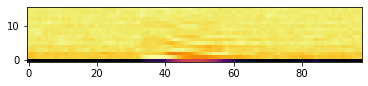

In [18]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

#idx = 13
idx = 5

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [19]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [20]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 9 (16, 96)
Dropped: 22 (16, 82)
Dropped: 38 (16, 91)
Dropped: 41 (16, 84)
Dropped: 42 (16, 74)
Dropped: 50 (16, 82)
Dropped: 57 (16, 92)
Dropped: 59 (16, 82)
Dropped: 60 (16, 59)
Dropped: 65 (16, 91)
Dropped: 94 (16, 82)
Dropped: 108 (16, 91)
Dropped: 110 (16, 75)
Dropped: 116 (16, 64)
Dropped: 147 (16, 91)
Dropped: 154 (16, 96)
Dropped: 179 (16, 54)
Dropped: 203 (16, 77)
Dropped: 220 (16, 92)
Dropped: 222 (16, 74)
Dropped: 231 (16, 96)
Dropped: 234 (16, 75)
Dropped: 250 (16, 58)
Dropped: 264 (16, 54)
Dropped: 283 (16, 82)
Dropped: 312 (16, 84)
Dropped: 314 (16, 79)
Dropped: 319 (16, 87)
Dropped: 321 (16, 82)
Dropped: 322 (16, 67)
Dropped: 336 (16, 82)
Dropped: 347 (16, 84)
Dropped: 351 (16, 79)
Dropped: 356 (16, 74)
Dropped: 377 (16, 91)
Dropped: 378 (16, 74)
Dropped: 380 (16, 88)
Dropped: 392 (16, 92)
Dropped: 399 (16, 82)
Dropped: 401 (16, 91)
Dropped: 423 (16, 92)
Dropped: 461 (16, 62)
Dropped: 462 (16, 91)
Dropped: 473 (16, 96)
Dropped: 477 (16, 68)
Dropped: 496 (16, 31)


In [21]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [22]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [23]:
len(feature_sets['x_test'])

161

In [24]:
print(feature_sets['y_val'])

[1. 2. 2. 2. 1. 2. 2. 2. 2. 0. 2. 2. 0. 0. 0. 2. 2. 0. 2. 2. 1. 2. 2. 2.
 2. 0. 0. 2. 2. 0. 2. 1. 2. 2. 2. 2. 2. 0. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2.
 0. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 0. 2. 0. 2. 2. 2. 2. 2. 1. 2. 2. 0. 1.
 2. 0. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 0. 1. 1. 1. 1. 0.
 2. 2. 2. 2. 2. 2. 1. 0. 2. 1. 1. 1. 0. 2. 0. 2. 1. 2. 1. 2. 2. 2. 1. 2.
 2. 2. 2. 2. 1. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 0. 0. 2. 2. 2. 1. 2.
 2. 2. 2. 1. 0. 1. 2. 2. 2. 1. 0. 2. 2. 2. 1. 1. 0. 1. 1. 2. 2. 2. 2. 1.
 1. 2. 2. 1. 2. 2. 2. 0. 0. 1. 2. 2. 0. 2. 2. 2. 0. 2. 2. 1. 2. 2. 2. 1.
 1. 1. 2. 2. 1. 2. 0. 2. 2. 0. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 1. 1. 2. 2. 2. 2. 2. 1. 2. 0. 2.
 0. 2. 2. 0. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 1. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 1. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 0. 2. 2. 0. 2. 0. 2. 2.
 2. 2. 0. 0. 2. 2. 1. 0. 2. 2. 0. 2. 2. 0. 2. 0. 2. 2. 2. 2. 2. 2. 2. 1.
 2. 0. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2.

In [25]:
len(feature_sets['y_val'])

347

In [26]:
print(feature_sets['y_train'])

[2. 1. 2. ... 2. 0. 1.]
